# Model Inversion & Stealing

In [1]:
#!pip install -r requirements.txt
import numpy as np
import torch
from torchvision import transforms, datasets
from torchvision.utils import save_image

import unsplit.attacks as unsplit
from unsplit.models import *
from unsplit.util import *

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device_count())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

True
0
1


device(type='cuda')

Change the dataset and split layer values as desired. Dataset can be one of `mnist`, `f_mnist`, or `cifar` while the split depth is between 1 and 6 for MNIST datasets, and 1 and 8 for the CIFAR dataset.

In [3]:
split_layer = 1

In [4]:
dataset = 'mnist'

if dataset == 'mnist':
    trainset = datasets.MNIST('data/mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.MNIST('data/mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'f_mnist':
    trainset = datasets.FashionMNIST('data/f_mnist', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.FashionMNIST('data/f_mnist', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = MnistNet(), MnistNet(), MnistNet()
elif dataset == 'cifar':
    trainset = datasets.CIFAR10('data/cifar', download=True, train=True, transform=transforms.ToTensor())
    testset = datasets.CIFAR10('data/cifar', download=True, train=False, transform=transforms.ToTensor())
    client, server, clone = CifarNet(), CifarNet(), CifarNet()

trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=64)
testloader = torch.utils.data.DataLoader(testset, shuffle=True)

The next part trains the client and server models. You can skip this step and launch the attack directly as well.

In [5]:
for images, labels in trainloader:
    for image in images:
        image = image.to(device)
    for label in labels:
        label = label.to(device)

In [6]:
client_opt = torch.optim.Adam(client.parameters(), lr=0.001, amsgrad=True)
server_opt = torch.optim.Adam(server.parameters(), lr=0.001, amsgrad=True)
criterion = torch.nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        client_opt.zero_grad()
        server_opt.zero_grad()

        pred = server(client(images, end=split_layer), start=split_layer+1)

        loss = criterion(pred, labels)
        loss.backward()
        running_loss += loss

        server_opt.step()
        client_opt.step()
    else:
        print(f'Epoch: {epoch} Loss: {running_loss / len(trainloader)} Acc: {get_test_score(client, server, testset, split=split_layer)}')


Epoch: 0 Loss: 0.28899621963500977 Acc: 97.87581699346406
Epoch: 1 Loss: 0.07781976461410522 Acc: 98.08847624249044
Epoch: 2 Loss: 0.053563885390758514 Acc: 98.51729818780889
Epoch: 3 Loss: 0.041740380227565765 Acc: 98.51075565361279
Epoch: 4 Loss: 0.03346892073750496 Acc: 99.17264202978488
Epoch: 5 Loss: 0.028300194069743156 Acc: 98.6827661909989
Epoch: 6 Loss: 0.023367343470454216 Acc: 99.44994499449945
Epoch: 7 Loss: 0.020400304347276688 Acc: 98.89685603971319
Epoch: 8 Loss: 0.01783980056643486 Acc: 99.33554817275747
Epoch: 9 Loss: 0.015998249873518944 Acc: 99.1223258365332


We are now ready to launch the attack. The next code cell loads `COUNT` many examples from each class of the dataset. Those examples will be used as targets in the attack.

In [7]:
def display_imagelist(images, height, width, count=1):
    fig, ax = plt.subplots(count, len(images)) #1
    if count == 1:
        for index, image in enumerate(images):
            ax[index].axis('off')
            ax[index].imshow(image.cpu().detach().reshape(height, width))
    else:
        for id, nested in enumerate(images):
            for index, image in enumerate(nested):
                ax[index, id].axis('off')
                ax[index, id].imshow(image.cpu().detach().reshape(height, width))
    plt.show()

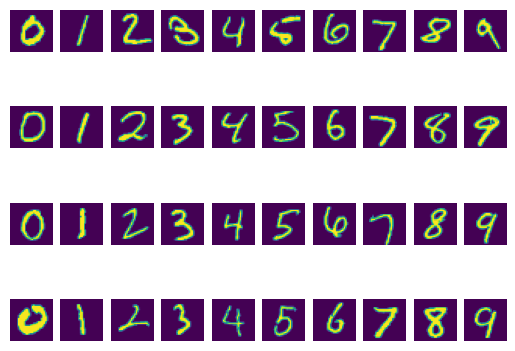

In [8]:
COUNT = 4

inversion_targets = [get_examples_by_class(testset, c, count=COUNT) for c in range(10)]
targetloader = torch.utils.data.DataLoader(inversion_targets, shuffle=False)
mse = torch.nn.MSELoss()

display_imagelist(inversion_targets, 28, 28, count=COUNT)

We now launch the attack, iterating over the examples from the previous cell.

You can change the `main_iters`, `input_iters`, and `model_iters` variables to observe how the attack performs under different configurations.

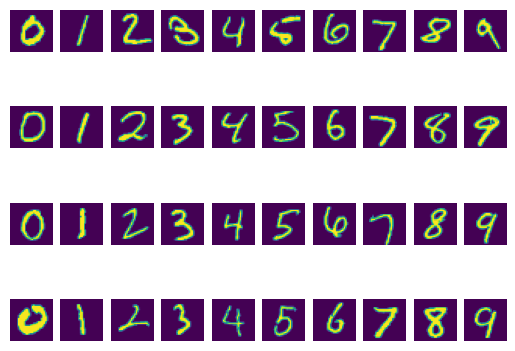

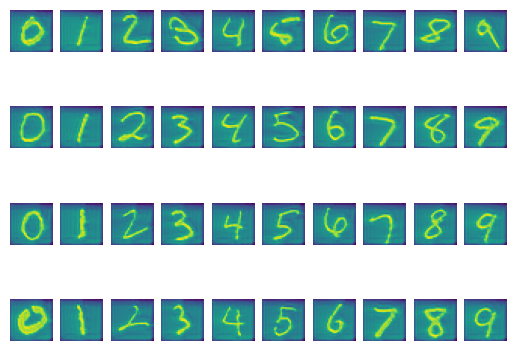

In [142]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT TOTAL VARIATION

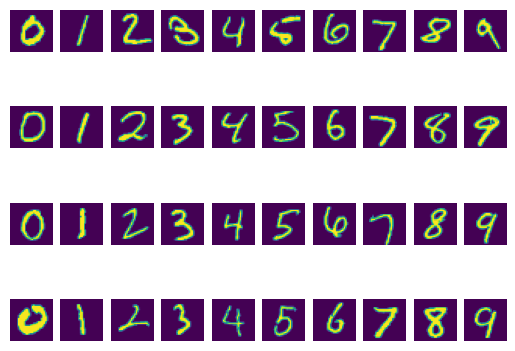

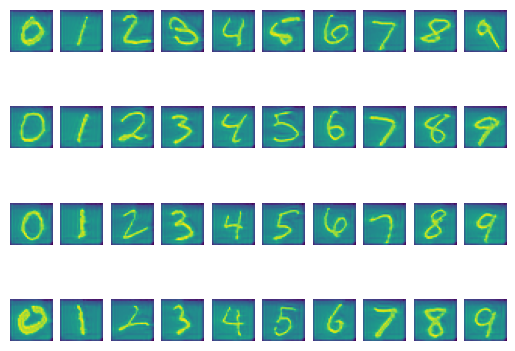

In [143]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_tv=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT L2 W TOTAL VARIANTION

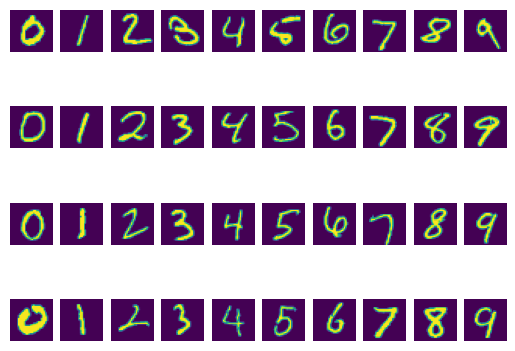

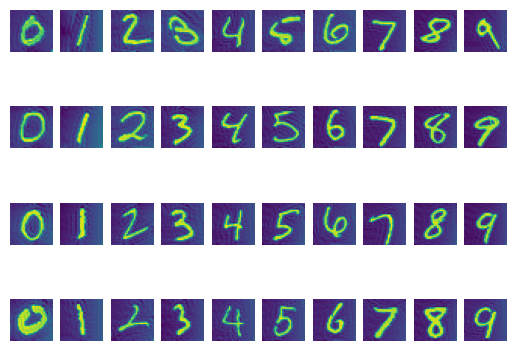

In [144]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

WITHOUT EVERYTHING

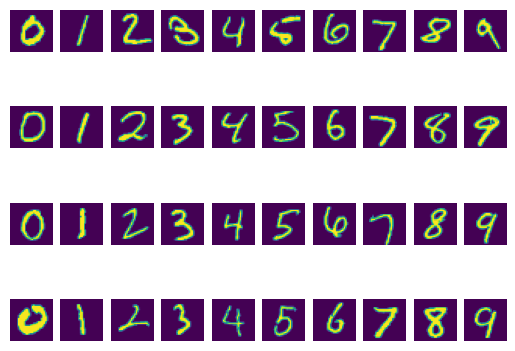

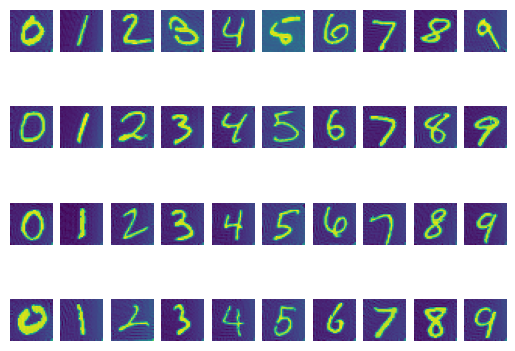

In [145]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=5, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

# The same on 1000 iterations. Parameters: split 1 COUNT 4.

With everything

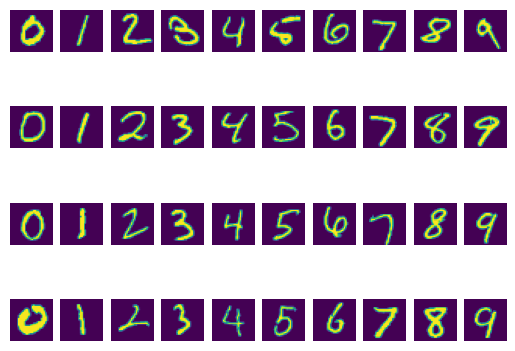

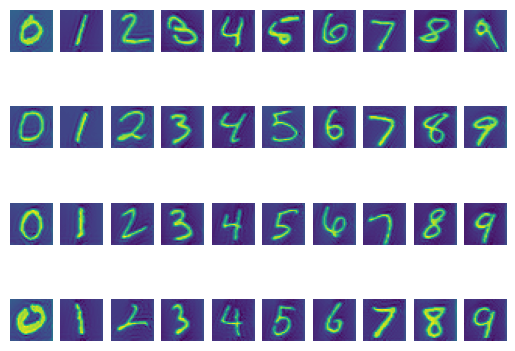

In [25]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

without total variation

In [11]:
target = target.to(device)
print(target.device)
clone = clone.to(device)
print(clone)
client = client.to(device)
#result = result.to(device)
#print(result.device)

cuda:0
MnistNet(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (ReLU1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (ReLU2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc1act): ReLU()
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc2act): ReLU()
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [13]:
def model_inversion_stealing(clone_model, split_layer, target, input_size, 
                            lambda_tv=0.1, lambda_l2=1, main_iters=1000, input_iters=100, model_iters=100, device=None):
    x_pred = torch.empty(input_size).fill_(0.5).to(device).requires_grad_()
    print("x_pred is leaf: ", x_pred.is_leaf)
    input_opt = torch.optim.Adam([x_pred], lr=0.001, amsgrad=True)
    model_opt = torch.optim.Adam(clone_model.parameters(), lr=0.001, amsgrad=True)
    mse = torch.nn.MSELoss()

    for main_iter in range(main_iters):
        for input_iter in range(input_iters):
            input_opt.zero_grad()
            pred = clone_model(x_pred, end=split_layer).to(device)
            loss = mse(pred, target) + lambda_l2*l2loss(x_pred) + lambda_tv*TV(x_pred)
            loss.backward(retain_graph=True)
            input_opt.step()
        for model_iter in range(model_iters):
            model_opt.zero_grad()
            pred = clone_model(x_pred, end=split_layer)
            loss = mse(pred, target) 
            loss.backward(retain_graph=True)
            model_opt.step()

    return x_pred.detach()

target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:0
client_out:  cuda:0
x_pred is leaf:  True
target:  cuda:

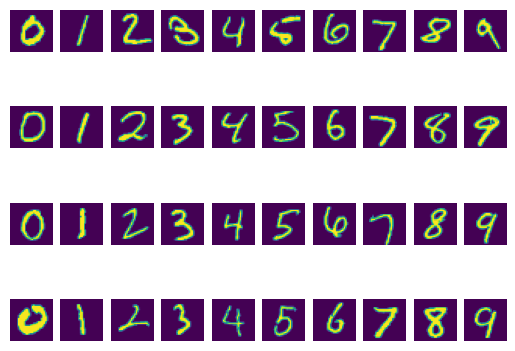

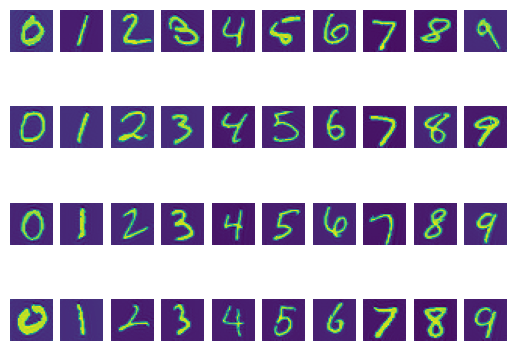

In [14]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)
        print(client_out.device)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            target = target.to(device)
            print("target: ", target.device)
            client_out = client(target, end=split_layer)
            print("client_out: ", client_out.device)
            clone = clone.to(device)
    
            result = model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_tv=0.0, device=device)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

without l2

In [ ]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_l2=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_l2=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)

without everything

In [ ]:
results, losses = [], []
#for idx, target in enumerate(targetloader):
for _, nested in enumerate(targetloader):
    if COUNT == 1: 
    # obtain client output
        client_out = client(target, end=split_layer)

        # perform the attack
        result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

        # save result
        if dataset == 'cifar':
            result = normalize(result)
        results.append(result)
        loss = mse(result, target)
        losses.append(loss)
    else:
        for idx, target in enumerate(nested):
            client_out = client(target, end=split_layer)
            result = unsplit.model_inversion_stealing(clone, split_layer, client_out, target.size() ,main_iters=1000, input_iters=100, model_iters=100, lambda_l2=0.0, lambda_tv=0.0)

            if dataset == 'cifar':
                result = normalize(result)
            results.append(result)
            loss = mse(result, target)
            losses.append(loss)

            #display_imagelist(inversion_targets, 28, 28, count=COUNT)
            #display_imagelist(results, 28, 28, count=COUNT)

if dataset == 'cifar':
    display_cifar(inversion_targets)
    display_cifar(results)
else:
    display_imagelist(inversion_targets, 28, 28, count=COUNT)
    reshaped_results = [results[i*COUNT:(i+1)*COUNT] for i in range(10)]
    display_imagelist(reshaped_results, 28, 28, count=COUNT)